<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/SPI1_regression/TrainRegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
![[ -e SPI1_negatives.tsv.gz ]] || wget -O SPI1_negatives.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_negatives.tsv.gz -O SPI1_negatives.tsv.gz
![[ -e SPI1_positives_regression_labels.tsv.gz ]] || wget -O SPI1_positives_regression_labels.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_positives_regression_labels.tsv.gz

#download hg38 fasta file
![[ -e hg38.fa ]] || wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O hg38.fa.gz
![[ -e hg38.fa ]] || gunzip hg38.fa.gz

#install pyfaidx and prepare an index for hg38.fa
!pip install pyfaidx
from pyfaidx import Fasta
Fasta("hg38.fa") #this will build the index if it does not exist

Fasta("hg38.fa")

In [0]:
![[ -e noheader_SPI1_negatives.tsv.gz ]] || zcat SPI1_negatives.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_negatives.tsv.gz
![[ -e noheader_SPI1_positives_regression_labels.tsv.gz ]] || zcat SPI1_positives_regression_labels.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_positives_regression_labels.tsv.gz

!zcat noheader_SPI1_negatives.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_positives_regression_labels.tsv.gz
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_SPI1_coords.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c >> test_SPI1_coords.tsv.gz

In [0]:
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_positives_regression_labels.tsv.gz

In [34]:
#num negs in validation set
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22'  | wc -l

995472


In [35]:
#num pos in validation set
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | wc -l

6127


In [36]:
#combine the positives and negatives in the validation set; subsample the
# validation set for speed of calculation
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22' | perl -ne 'if ($.%25==0) {print $_}' | gzip -c > negsubsampled_valid.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | gzip -c >> negsubsampled_valid.tsv.gz
!zcat negsubsampled_valid.tsv.gz | wc -l

45945


In [6]:
!git clone https://github.com/kundajelab/seqdataloader.git

fatal: destination path 'seqdataloader' already exists and is not an empty directory.


In [7]:
%cd /content/seqdataloader
!git checkout downsamplenegatives
!git pull
!pip uninstall seqdataloader
!pip install .
%cd /content

/content/seqdataloader
Already on 'downsamplenegatives'
Your branch is up to date with 'origin/downsamplenegatives'.
Already up to date.
Uninstalling seqdataloader-0.126:
  Would remove:
    /usr/local/bin/db_ingest
    /usr/local/bin/genomewide_labels
    /usr/local/lib/python3.6/dist-packages/seqdataloader-0.126.dist-info/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/batchproducers/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/dbingest/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/labelgen/*
Proceed (y/n)? y
  Successfully uninstalled seqdataloader-0.126
Processing /content/seqdataloader
  Created wheel for seqdataloader: filename=seqdataloader-0.126-cp36-none-any.whl size=27287 sha256=42db5dc66dccf4febdc8c8bca0acd43aff93d71e06758a84d24b3c9c25acaed5
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_xz6sp0/wheels/c2/db/13/112d41662f69fb8c7986c218293570cc1550fc21eed966e31b
Successfully built seqdataloader
/content


In [1]:
from seqdataloader.batchproducers import coordbased
import numpy as np

labels_coordstovals = coordbased.coordstovals.lookup.SimpleLookup(
    lookup_file="noheader_SPI1_positives_regression_labels.tsv.gz")
input_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
    genome_fasta_path="hg38.fa")

valid_batchproducer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
    bed_file="negsubsampled_valid.tsv.gz",
    batch_size=64,
    shuffle_before_epoch=False,
    seed=None)

train_batchproducer = (
  coordbased.coordbatchproducers.DownsampleNegativesCoordsBatchProducer(
    pos_bed_file="minitrain_SPI1_positives_regression_labels.tsv.gz",
    neg_bed_file="minitrain_SPI1_negatives.tsv.gz",
    target_proportion_positives=0.5,
    batch_size=64,
    shuffle_before_epoch=True,
    seed=1234))

train_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=train_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=labels_coordstovals,
    coordsbatch_transformer=\
      coordbased.coordbatchtransformers.ReverseComplementAugmenter())

valid_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=valid_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=labels_coordstovals)


Using TensorFlow backend.


Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Reading in positive bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 31302  coords in positive bed file
Reading in negative bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 4881439  coords in negative bed file
The target proportion of positives of 0.5 requires the negative set to be subsampled by a factor of 156 which will result in a #neg of 31291
Using an offset of  0  before striding


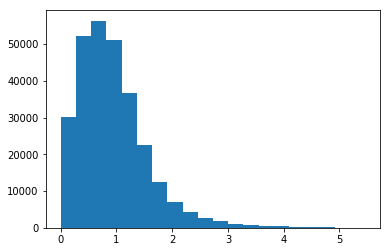

In [2]:
vals = list(labels_coordstovals.lookup.values())
from matplotlib import pyplot as plt
plt.hist(np.array(vals).squeeze(), bins=20)
plt.show()

In [0]:
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback

class CatchOverfittingOnPositives(Callback):
  
  def __init__(self, validation_data, patience):
    self.validation_data = validation_data
    self.patience = patience
    self.epochs_waited = 0
    self.best_positives_loss = None
    self.best_weights = None
    self.positives_mse_history = []
    self.negatives_mse_history = []
    self.stopped_epoch = None
    
  def on_epoch_end(self, epoch, *args, **kwargs):
    
    total_positives_mse = 0
    num_positives = 0
    total_negatives_mse = 0
    num_negatives = 0
    for batch_num in len(validation_data):
      batch_inputs, batch_labels = validation_data[batch_num]
      batch_labels = batch_labels["output"]
      batch_preds = self.model.predict(batch_inputs)["output"]
      
      positives_mask = batch_labels > 0.0
      negatives_mask = positives_mask==False
      num_positives += np.sum(positives_mask)
      total_positives_mse += np.square(
          batch_labels[positives_mask] - batch_preds[positives_mask])
      num_negatives += np.sum(negatives_mask)
      total_negatives_mse += np.square(
          batch_labels[negatives_mask] - batch_preds[negatives_mask])
    
    positives_mse = total_positives_mse/num_positives
    negatives_mse = total_negatives_mse/num_negatives
    
    self.positives_mse_history.append(positives_mse)
    self.negatives_mse_history.append(negatives_mse)
    
    print("Mean mse over",num_positives,"positives is",positives_mse)
    print("Mean mse over",num_negatives,"negatives is",negatives_mse)
    
    if (self.best_positives_loss is None or
        self.best_positives_loss >= positives_mse):
      self.best_weights = self.model.get_weights()
      self.best_positives_loss = positives_mse
      self.epochs_waited = 0
    else:
      self.epochs_waited += 1
      if (self.epochs_waited >= self.patience):
        self.stopped_epoch = epoch
        self.model.stop_training = True
        print("Restoring weights from the best epoch")
        self.model.set_weights(self.best_weights)
    

def manual_mse(y_true, y_pred):
  return K.mean(K.square(y_pred-y_true), axis=-1)

def mse_on_positives(y_true, y_pred):
  the_mask = tf.greater(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)

def mse_on_negatives(y_true, y_pred):
  the_mask = tf.equal(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)


def get_model(num_conv_filters,
              conv_filter_length,
              pool_length_and_stride,
              num_dense_units):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1batchnorm = keras.layers.normalization.BatchNormalization()(conv1)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1batchnorm)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2batchnorm = keras.layers.normalization.BatchNormalization()(conv2)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2batchnorm)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3batchnorm = keras.layers.normalization.BatchNormalization()(conv3)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3batchnorm)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units)(flatten)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
  dense2 = keras.layers.core.Dense(units=num_dense_units)(dense1relu)
  dense2relu = keras.layers.core.Activation(activation="relu")(dense2)
  output = keras.layers.core.Dense(units=1,
                                   name="output")(dense2relu)
  conv_model = keras.models.Model(inputs=input, outputs=output)
  conv_model.compile(optimizer=keras.optimizers.Adam(),
                     loss={"output": "mse"},
                     metrics=[mse_on_positives,
                              mse_on_negatives,
                              manual_mse])
  return conv_model

conv_model = get_model(num_conv_filters=30,
                       conv_filter_length=15,
                       pool_length_and_stride=40,
                       num_dense_units=30)

conv_model.summary()
early_stopping_callback = CatchOverfittingOnPositives(
                              validation_data=valid_batch_generator,
                              patience=3)
fit_history = conv_model.fit_generator(
  generator=train_batch_generator,
  validation_data=valid_batch_generator,
  epochs=100,
  callbacks=[early_stopping_callback]
)
#the callback isn't triggered if the upper epoch limit is hit,
# so make sure the set the weights from the best epoch at the end
conv_model.set_weights(early_stopping_callback.best_weights)

W0904 05:06:43.459302 140446837237632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 05:06:43.475053 140446837237632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 05:06:43.476441 140446837237632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 05:06:43.556221 140446837237632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0904 05:06:43.759117 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 30)          1830      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 30)          120       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 30)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 30)          13530     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 30)          120       
_________________________________________________________________
activation_2 (Activation)    (None, 1000, 30)          0   

W0904 05:06:44.351416 140446837237632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
747/979 [=====================>........] - ETA: 26s - loss: 0.2605 - mse_on_positives: 0.8242 - mse_on_negatives: 0.0728 - manual_mse: 0.2605

In [0]:

from google.colab import files
files.download